# Compare a randomized train / validation / test split with splitting by session

## Set-up

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 42.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
from fastai.vision import *

In [ ]:
def composition(df, column):
  info = pd.DataFrame(columns=['label', 'count', 'percent'])

  counts = df[column].value_counts()
  percents = df[column].value_counts(normalize=True) * 100
  labels = np.unique(df[column])

  for label in labels:
    info = info.append({
        'label': label,
        'count': counts[label],
        'percent': percents[label]
        },
        ignore_index=True)
  
  return info

## Random split

#### Load the testing set

When this script was originally run, `all_labels_path_metric_2_test.csv` contained the test set and the validation set used for selecting hyperparameters. The validation set was contained in `random_split/validation.csv`, so the commented code filtered the test set CSV to only contain the test set.

The code below now loads the full test set directly.

In [ ]:
path = '/gdrive/My Drive/Labeling'
model_path = os.path.join(path, 'Model')
image_path = os.path.join(model_path, 'Images')

In [ ]:
# v = pd.read_csv(os.path.join(path, 'LabelsCSV', 'random_split', 'validation.csv'))
# test_with_validation = pd.read_csv(os.path.join(path, 'LabelsCSV', 'all_labels_path_metric_2_test.csv'))
# test = test_with_validation[test_with_validation['image'].apply(lambda x: x not in np.unique(v['image']))]

test = pd.read_csv(os.path.join(path, 'LabelsCSV', 'random_split', 'Metric2', 'all_labels_path_metric_2_test.csv'))

In [ ]:
# print(len(v))
# print(len(test_with_validation))
print(len(test))

354
1414
1060


#### Check the composition of the test set

In [ ]:
composition(test, 'group_2')

,label,count,percent
0,0.0,796.0,75.09434
1,1.0,264.0,24.90566


In [ ]:
composition(test, 'group_4')

,label,count,percent
0,0.0,455.0,42.924528
1,1.0,367.0,34.622642
2,2.0,195.0,18.396226
3,3.0,43.0,4.056604


#### v12

In [ ]:
# Test set
test_v12 = test.filter(items=['image', 'group_2'])
test_v12['group_2'] = test_v12['group_2'].astype(int).astype(str)
test_v12['is_valid'] = True

# Placeholder training data to load into the model
test_v12_train = test_v12.copy(deep=True)
test_v12_train['is_valid'] = False
test_v12_train = test_v12_train[0:64]

test_v12 = test_v12.append(test_v12_train)

In [ ]:
print(len(test_v12))

1124


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=test_v12)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        # .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
1060 1060


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'v12', 'v12-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.6396)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

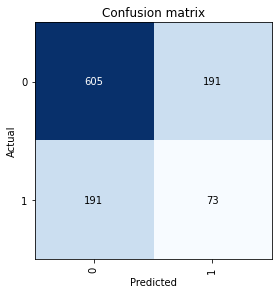

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=test_v12)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
learn.data = data

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.6991)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

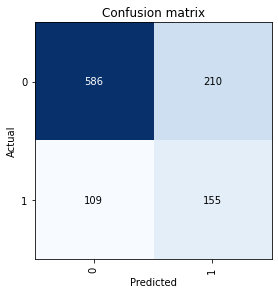

In [ ]:
interp.plot_confusion_matrix()

#### v14

In [ ]:
# Test set
test_v14 = test.filter(items=['image', 'group_4'])
test_v14['group_4'] = test_v14['group_4'].astype(int).astype(str)
test_v14['is_valid'] = True

# Placeholder training data to load into the model
test_v14_train = test_v14.copy(deep=True)
test_v14_train['is_valid'] = False
test_v14_train = test_v14_train[0:64]

test_v14 = test_v14.append(test_v14_train)

In [ ]:
print(len(test_v14))

1124


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=test_v14)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
1060 1060


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.load(os.path.join(model_path, 'v14', 'v14-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.5132)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

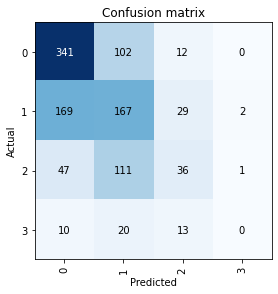

In [ ]:
interp.plot_confusion_matrix()

## Split within session

#### Load the test set

In [ ]:
labels = pd.read_csv(os.path.join(path, 'LabelsCSV', 'split_within_session', 'labels_path_validated_split_metric_2.csv'))
test_2 = labels[labels['dataset']=='test']

In [ ]:
print(len(labels))
print(len(test_2))

7061
1060


#### Check the composition of the test set

In [ ]:
composition(test_2, 'group_2')

,label,count,percent
0,0.0,804.0,75.849057
1,1.0,256.0,24.150943


In [ ]:
composition(test_2, 'group_4')

,label,count,percent
0,0.0,424.0,40.000000
1,1.0,407.0,38.396226
2,2.0,187.0,17.641509
3,3.0,42.0,3.962264


#### v16

In [ ]:
# Test set
test_v16 = test_2.filter(items=['image', 'group_2'])
test_v16['group_2'] = test_v16['group_2'].astype(int).astype(str)
test_v16['is_valid'] = True

# Placeholder training data to load into the model
test_v16_train = test_v16.copy(deep=True)
test_v16_train['is_valid'] = False
test_v16_train = test_v16_train[0:64]

test_v16 = test_v16.append(test_v16_train)

In [ ]:
print(len(test_v16))

1124


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=test_v16)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
1060 1060


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'split_within_session', 'v16', 'v16-1-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.7019)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

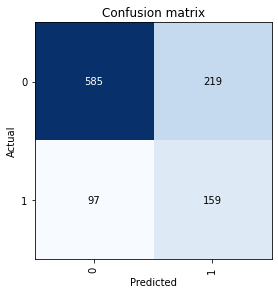

In [ ]:
interp.plot_confusion_matrix()

#### v17

In [ ]:
# Test set
test_v17 = test_2.filter(items=['image', 'group_4'])
test_v17['group_4'] = test_v17['group_4'].astype(int).astype(str)
test_v17['is_valid'] = True

# Placeholder training data to load into the model
test_v17_train = test_v17.copy(deep=True)
test_v17_train['is_valid'] = False
test_v17_train = test_v17_train[0:64]

test_v17 = test_v17.append(test_v17_train)

In [ ]:
print(len(test_v17))

1124


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=test_v17)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
1060 1060


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'split_within_session', 'v17', 'v17-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.5292)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

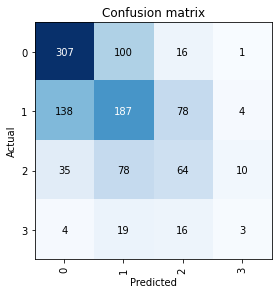

In [ ]:
interp.plot_confusion_matrix()

## Confusion matrix to accuracy by class

In [ ]:
def accuracy_by_class(cm):
  accuracies = []

  for i in range(len(cm)):
    row_total = 0
    num_correct = 0
    for j in range(len(cm[0])):
      row_total += cm[i][j]
      if i == j:
        num_correct = cm[i][j]
    
    accuracy = round((num_correct/row_total) * 100, 2)
    accuracies.append(accuracy)
    print('Class', i, ':', accuracy)
  
  print('Average:', round(sum(accuracies) / len(accuracies), 2))

In [ ]:
cm_random_2 = [[586, 210], [109, 155]]
accuracy_by_class(cm_random_2)

Class 0 : 73.62
Class 1 : 58.71
Average: 66.17


In [ ]:
cm_random_4 = [[341, 102, 12, 0],
               [169, 167, 29, 2],
               [47, 111, 36, 1],
               [10, 20, 13, 0]]
accuracy_by_class(cm_random_4)

Class 0 : 74.95
Class 1 : 45.5
Class 2 : 18.46
Class 3 : 0.0
Average: 34.73


In [ ]:
cm_split_within_session_2 = [[585, 219], [97, 159]]
accuracy_by_class(cm_split_within_session_2)

Class 0 : 72.76
Class 1 : 62.11
Average: 67.44


In [ ]:
cm_split_within_session_4 = [[307, 100, 16, 1],
               [138, 187, 78, 4],
               [35, 78, 64, 10],
               [4, 19, 16, 3]]
accuracy_by_class(cm_split_within_session_4)

Class 0 : 72.41
Class 1 : 45.95
Class 2 : 34.22
Class 3 : 7.14
Average: 39.93
